In [1]:
from scipy.integrate import odeint
from scipy import arange, tanh, cosh, floor
import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
### Morris Lecar Model Class
class morrisLecar:
    ## Must be in same order as dXdt return
    label = ['v', 'w']
    nVar = len(label)

    ## Parameters
    p = {
    'C_m': 1.0,    # membrane capacitance, in uF/cm^2
    'g_Ca': 1.1,   # Ca maximum conducances, in mS/cm^2
    'g_K': 2.0,    # K maximum conducances, in mS/cm^2
    'g_L': 0.5,    # Leak maximum conducances, in mS/cm^2
    'E_Ca': 100.0, # Ca Nernst reversal potentials, in mV
    'E_K': -70.0,  # K Nernst reversal potentials, in mV
    'E_L': -50.0   # Leak Nernst reversal potentials, in mV
    }

    ## Get initial values for the system
    def __init__(self, X0 = [0.2, 0.1]):
        self.name = self.__class__.__name__
        if self.nVar != len(X0):
            print 'ERROR:', self.nVar, 'initial values required for:', self.name
        else: 
            self.X0 = X0
            
    ## Channel gating kinetics
    ## Functions of membrane voltage
    def m_infty(self, v): return (1.0 + tanh((v + 1.0) / 15.0)) / 2.0
    def w_infty(self, v): return (1.0 + tanh(v / 30.0)) / 2.0
    def tau_w(self, v):   return 5.0 / cosh(v / 60.0)  # in ms

    ## Membrane currents (in uA/cm^2)
    def I_Ca(self, v):    return self.p['g_Ca'] * self.m_infty(v) * (v - self.p['E_Ca'])
    def I_K(self, v, w):  return self.p['g_K'] * w * (v - self.p['E_K'])
    def I_L(self, v):     return self.p['g_L'] * (v - self.p['E_L'])
            
    ## External current
    ## step up 10 uA/cm^2 every 100ms
    def I_ext(self, t): 
        return 10*floor(t/150)
    
            
    ## Define the dX/dt for the system
    def dXdt(self, X, t):
        v, w = X

        dvdt = (self.I_ext(t) - self.I_Ca(v) - self.I_K(v, w) \
               - self.I_L(v)) / self.p['C_m']
        dwdt = (self.w_infty(v) - w) / self.tau_w(v)
      
        return dvdt, dwdt

In [40]:
## Time interval of the simulations
t = arange(0.0, 1000.0, 0.01)
m = morrisLecar()

## Solving the diffential equations
sol = odeint(m.dXdt, m.X0, t)

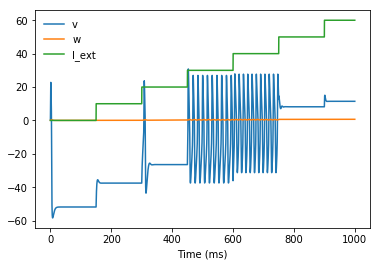

In [41]:
## Plot solution timeseries
fig, ax = plt.subplots()
for i, v in enumerate(m.label):
    figY = plt.plot(t, sol[:,i], label=v)
    
Iext = [m.I_ext(time) for time in t]
plt.plot(t, Iext, label='I_ext')

plt.xlabel('Time (ms)')
plt.legend(frameon=False)
plt.show()

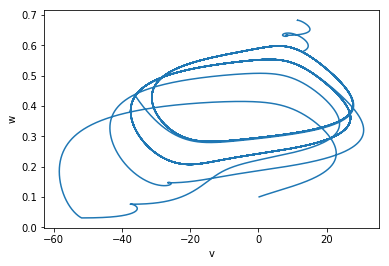

In [42]:
## Phase portrait
fig, ax = plt.subplots()

x, z = sol.T
plt.plot(x, z)

plt.xlabel('v')
plt.ylabel('w')
plt.show()